**Group 21:** Grégoire Bellan, Benjamin Cohen, Victor Manach, Hugues René-Bazin

In [1]:
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

# Scikit-learn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import tree,metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# Library for OverSampling
from imblearn.over_sampling import RandomOverSampler

# Library for Neural Networks
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

# Load data

In [2]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be integers. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [3]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [4]:
X = X.dropna()

## Split X and y

In [5]:
y = X.Category
X = X.drop('Category', axis=1)

## Class repartition

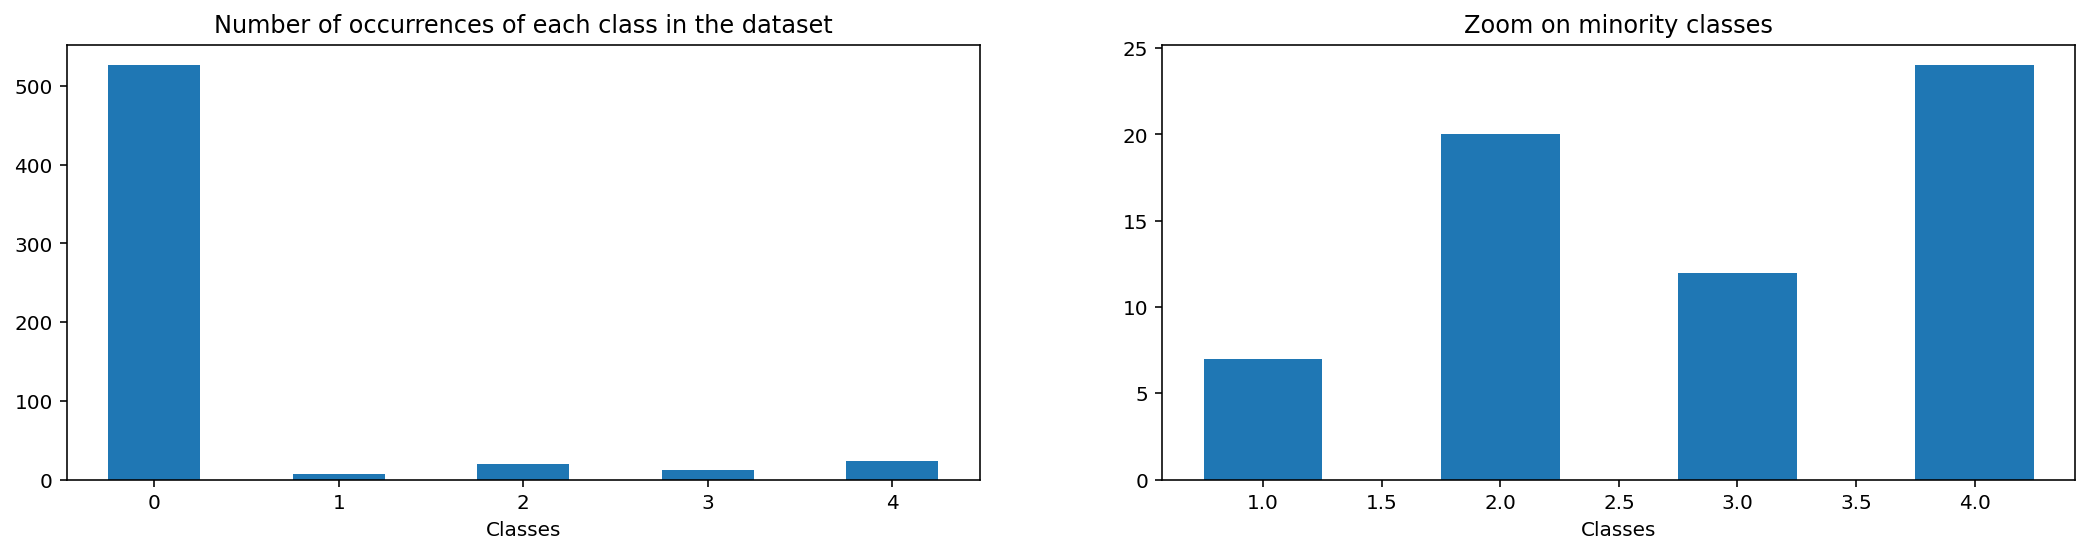

In [6]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.hist(y.values,bins=range(0,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Number of occurrences of each class in the dataset")

plt.subplot(1,2,2)
plt.hist(y[y!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Zoom on minority classes")
plt.show()

The repartition of the different classes of the data set clearly shows an imbalanced situation. With a class 0 representing approximately 90% of the whole dataset, we can predict that we need to take this feature into account in order to avoid our classifier to only predict well this class.

## Split the data in train and test split

**Ensure that all classes are well distributed**\
Here we have to ensure that all classes are represented in both the training and the testing set. Indeed having a class only in the training set will not allow us to test its performance on new entries of the same class. And having a class only in the testing set will result in an impossibility to train on this specific class.

To do so we can either do it manually or use a random state and check if the repartition is good (it is simpler and allows repeatability).

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=7)

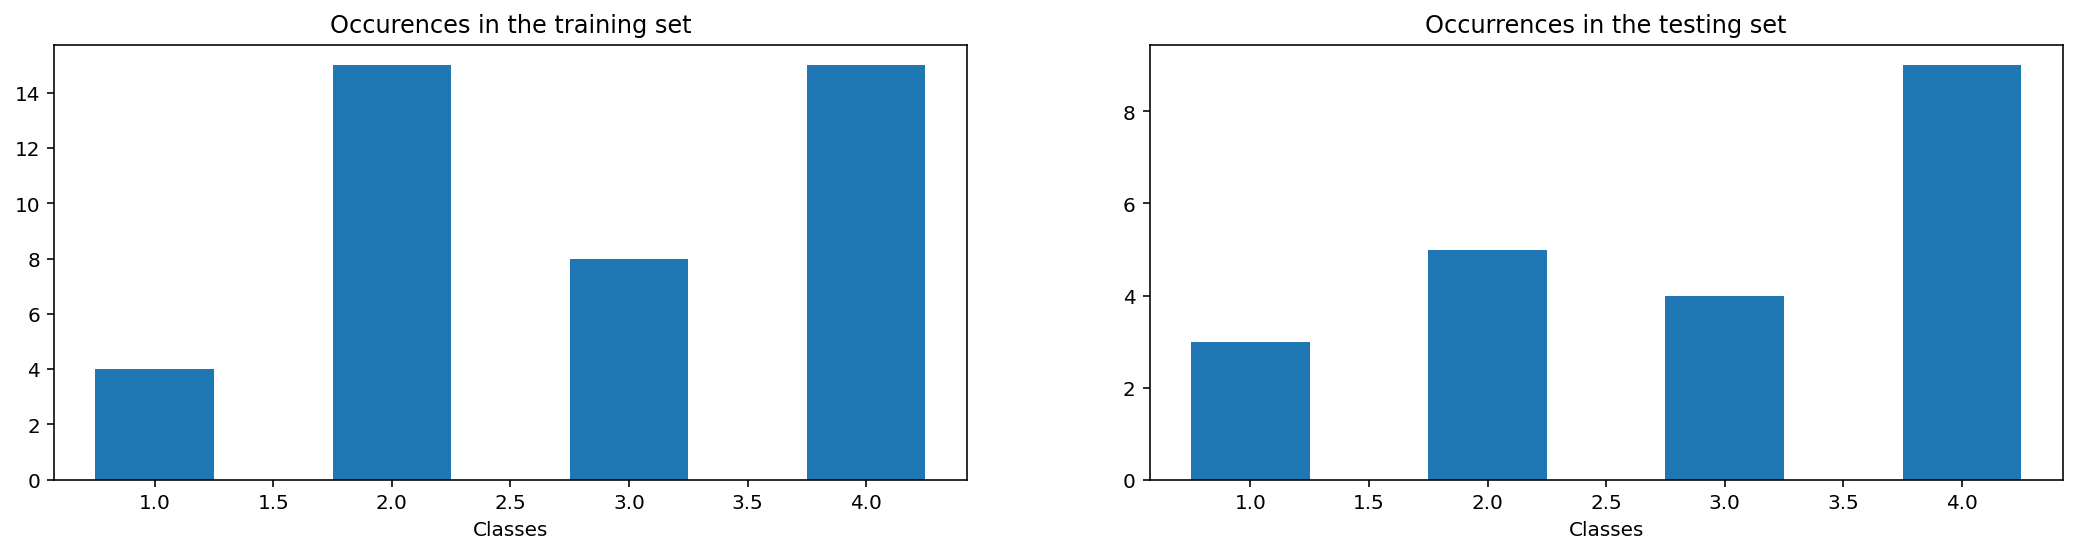

In [8]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.hist(y_train[y_train!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Occurences in the training set")

plt.subplot(1,2,2)
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Occurrences in the testing set")
plt.show()

We didn't plot the repartition for the class 0 as it is good and we focused on the minority classes. In this case we see that the repartition is satisfactory especially for the class 1 that has in total only 7 occurences. We managed to have 4 of them in the training set.

## Normalise the data

In [9]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Over sampling smaller categories

**Balancing the dataset**\
One solution is to oversample the minority classes. To do so it is important not to touch to the testing set and to over sample on the training set. Indeed, if we had oversampled on the whole data set and then split the data, we could have been confronted to the case where we have records both in the training and testing set.\
The idea is to duplicate randomly ligns in the training set in order to have the same amount of records for each classes. We used the imblearn library that implemented the RandomOverSampler function.

In [10]:
# Oversampling only on the train set
x_train_eq,y_train_eq = RandomOverSampler().fit_resample(x_train,y_train)

In [11]:
oc = np.unique(y_train_eq,return_counts=True)
print("The number of occurrences for each class is now: {}".format(oc[1]))

The number of occurrences for each class is now: [370 370 370 370 370]


# Decision tree

## Tree without balancing data

In [12]:
%%time
test_DT = DecisionTreeClassifier(criterion='gini',random_state=1)
test_DT.fit(x_train,y_train)

CPU times: user 5.87 ms, sys: 2.4 ms, total: 8.28 ms
Wall time: 6.75 ms


DecisionTreeClassifier(random_state=1)

In [13]:
print('Accuracy on the train set:', test_DT.score(x_train,y_train))
print('Accuracy on the test set:', test_DT.score(x_test,y_test))

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9322033898305084


In [14]:
y_pred_test = test_DT.predict(x_test)
matrix = confusion_matrix(y_test, y_pred_test)
pred_class_test = matrix.diagonal()/matrix.sum(axis=1)

print("The accuracy for each class is: {}".format(pred_class_test.round(2)))

The accuracy for each class is: [0.99 0.33 0.2  0.25 0.78]


The prediction is not bad but we have to keep in mind that 90% of the data is of class 0. Looking at the accuracy for each class we see that the prediciton for each minority class is bad. The "good" score comes from the fact that the accuracy on the class 0 is very good.

## Build the tree

**Balancing the decision tree**\
We have to possibilities: either to use the balanced data set we created or to use the class weight parameter in the function implemented by sklearn.

In [15]:
%%time
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=1)
clf.fit(x_train_eq, y_train_eq)

CPU times: user 8.36 ms, sys: 2.19 ms, total: 10.6 ms
Wall time: 9.65 ms


DecisionTreeClassifier(class_weight='balanced', random_state=1)

## Compute the accuracy of the tree

In [16]:
print('Accuracy on the train set:', clf.score(x_train, y_train))
print('Accuracy on the test set:', clf.score(x_test,y_test))

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9152542372881356


In [17]:
print("The depth of this decision tree is {}".format(clf.tree_.max_depth))

The depth of this decision tree is 10


## Improving the accuracy ?

The depth of the tree is 9 and corresponds to the case where the score on the training set is 1. There might be some overfitting. One way to check if we can improve the testing score while not affecting too much the training score is to force a reduction of the depth of the tree. We can do that with a GridSearchCV.

In [18]:
%%time
grid_DT = {'max_depth':np.arange(1,9)}
DT_cv = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_DT,cv=5)
DT_cv_res = DT_cv.fit(x_train_eq,y_train_eq)
DT_cv_res.best_params_

CPU times: user 233 ms, sys: 5.8 ms, total: 239 ms
Wall time: 244 ms


{'max_depth': 8}

In [19]:
print('Accuracy on the train set with depth reduction:', DT_cv.score(x_train_eq,y_train_eq))
print('Accuracy on the test set with depth reduction:', DT_cv.score(x_test,y_test))

Accuracy on the train set with depth reduction: 0.9989189189189189
Accuracy on the test set with depth reduction: 0.9209039548022598


The accuracy for each class is: [0.987 0.    0.4   0.25  0.667]


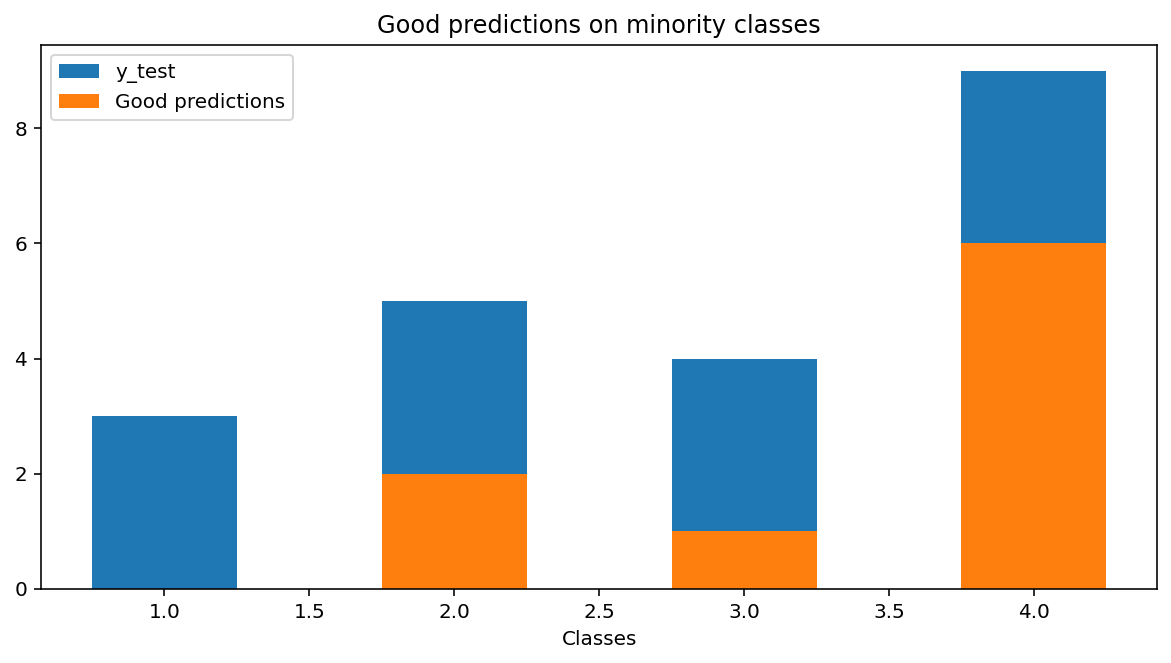

In [20]:
matrix_DT = confusion_matrix(y_test.values, DT_cv_res.predict(x_test))
acc_class_red = matrix_DT.diagonal()/matrix_DT.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_red.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_DT.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

This GridSearch improves a bit the testing score while not affecting too much the testing score.
Concerning minority classes we see that the accuracy on the class 1 and 4 has decreased but it has increased for the class 2. However it is still not satisfactory.

## Bagging

In [22]:
%%time
Bagging = BaggingClassifier(DecisionTreeClassifier(
    class_weight='balanced', max_depth=8), n_estimators=200)
# Here we use the parameter balanced to balance the class rather than using the data set we created as the results are better
Bagging.fit(x_train, y_train)
Bagging.score(x_test, y_test)

CPU times: user 532 ms, sys: 9.24 ms, total: 541 ms
Wall time: 548 ms


0.9491525423728814

In [23]:
bagging_grid = {'max_samples': np.arange(0.5, 1.0, 0.1)}
bagging_cv = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(
    class_weight='balanced', max_depth=8), n_estimators=200), param_grid=bagging_grid, cv=4)
# bagging_cv.fit(x_train_eq,y_train_eq) #to train on the oversampled training set
bagging_cv.fit(x_train, y_train)
bagging_cv.best_params_

{'max_samples': 0.7999999999999999}

In [24]:
print("Accuracy on the training set:",bagging_cv.score(x_train, y_train))
print("Accuracy on the testing set:",bagging_cv.score(x_test, y_test))

Accuracy on the training set: 1.0
Accuracy on the testing set: 0.9491525423728814


The accuracy for each class is: [1.    0.    0.6   0.25  0.889]


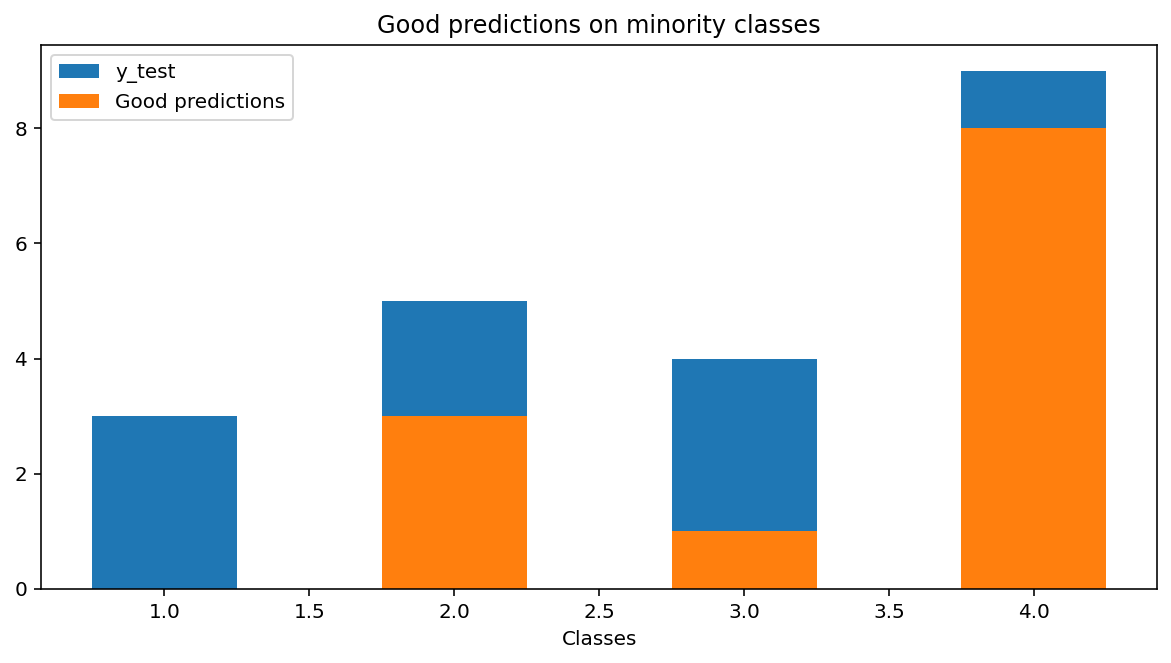

In [25]:
matrix_Bag = confusion_matrix(y_test.values, bagging_cv.predict(x_test))
acc_class_Bag = matrix_Bag.diagonal()/matrix_Bag.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_Bag.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_Bag.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

We observe a slight improvement on the overall testing score. But the accuracy on each class shows that some of them are not well predicted.

## Random forest

In [26]:
%%time 
RF = RandomForestClassifier(n_estimators=100,max_depth=9)
# It works better with our manually oversampled data set than with the class_weight option
RF.fit(x_train_eq, y_train_eq)
RF.score(x_test, y_test)

CPU times: user 218 ms, sys: 5.29 ms, total: 223 ms
Wall time: 227 ms


0.9491525423728814

In [27]:
%%time
param_RF = {'max_samples':np.arange(0.1,1.0,0.1)}
RF_cv = GridSearchCV(RandomForestClassifier(n_estimators=100),param_grid=param_RF,cv=5)
RF_cv.fit(x_train_eq,y_train_eq)
RF_cv.best_params_

CPU times: user 7.57 s, sys: 67.5 ms, total: 7.64 s
Wall time: 7.65 s


{'max_samples': 0.30000000000000004}

In [28]:
print("Accuracy for the training set: ",RF_cv.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",RF_cv.score(x_test, y_test))

Accuracy for the training set:  1.0
Accuracy for the testing set:  0.9491525423728814


The accuracy for each class is: [1.   0.   0.4  0.25 1.  ]


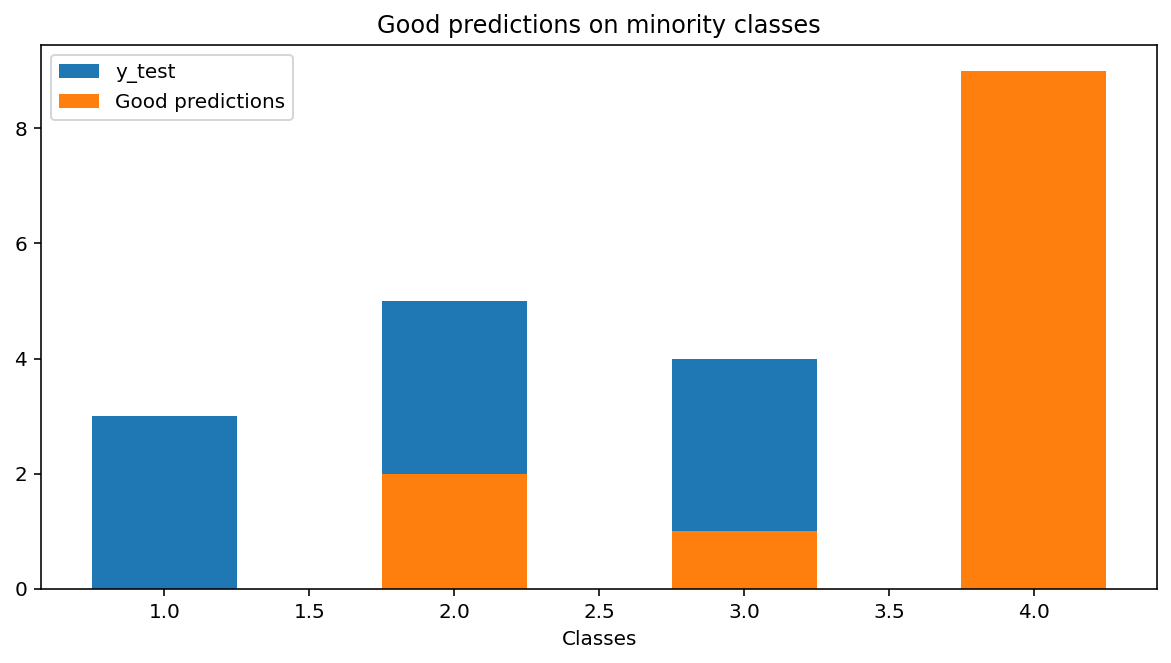

In [29]:
matrix_RF = confusion_matrix(y_test.values, RF_cv.predict(x_test))
acc_class_RF = matrix_RF.diagonal()/matrix_RF.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_RF.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_RF.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

As for Bagging we see that the overall prediction is a bit better. Looking at the accuracy for each class. We worsen the results on the second class while improving a bit the fourth class.

**Conclusion on decision trees**\
Decision trees offer a good testing score but it comes from the fact that they predict well the result on the class 0 which is in majority in the testing set. We need to explore other ways of classifying these data in order to perform better on the minority classes.

# SVM

## One versus one and one versus rest classifications

We first take a glance at the SVM for the training set without any balancing. We take a look at the two methods: one versus one and one versus the rest.

In [30]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(x_train, y_train)

clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(x_train,y_train)

SVC()

In [31]:
print("Accuracy for one vs one: ",clf_ovo.score(x_test, y_test))
print("Accuracy for one vs rest: ",clf_ovr.score(x_test, y_test))

Accuracy for one vs one:  0.943502824858757
Accuracy for one vs rest:  0.943502824858757


We obtain the same results with the two different methods. In the following we use the base method which is one versus one.

## SVM on oversampled dataset

We make the same reasoning using the oversampled dataset. Here the results are better using the data set we created than with the parameter 'balanced'.

In [32]:
%%time
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(x_train_eq, y_train_eq)

CPU times: user 46.6 ms, sys: 2.5 ms, total: 49.1 ms
Wall time: 65.3 ms


SVC()

In [33]:
print("Accuracy for the training set: ",clf_rbf.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",clf_rbf.score(x_test, y_test))

Accuracy for the training set:  0.985945945945946
Accuracy for the testing set:  0.9717514124293786


Here we see that the accuracy is good, better than in the case of Decision Trees. It may be possible to increase a bit the accuracy on the training set by making a cross validation.\
It is also worth to notice that it is not time consuming (less than 1 second of computation).

In [34]:
%%time
param_grid = {'C':np.arange(6,10,0.5)}
clf_rbf_cv = GridSearchCV(SVC(kernel='rbf'), param_grid,cv=5)
clf_rbf_cv.fit(x_train_eq, y_train_eq)
clf_rbf_cv.best_params_

CPU times: user 719 ms, sys: 4.61 ms, total: 724 ms
Wall time: 726 ms


{'C': 7.5}

In [35]:
print("Accuracy for the training set: ",clf_rbf_cv.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",clf_rbf_cv.score(x_test, y_test))

Accuracy for the training set:  1.0
Accuracy for the testing set:  0.9661016949152542


Doing a GridSearch produces a bit of overfitting so we keep the base SVM.

The accuracy for each class is: [0.987 0.667 0.8   0.75  1.   ]


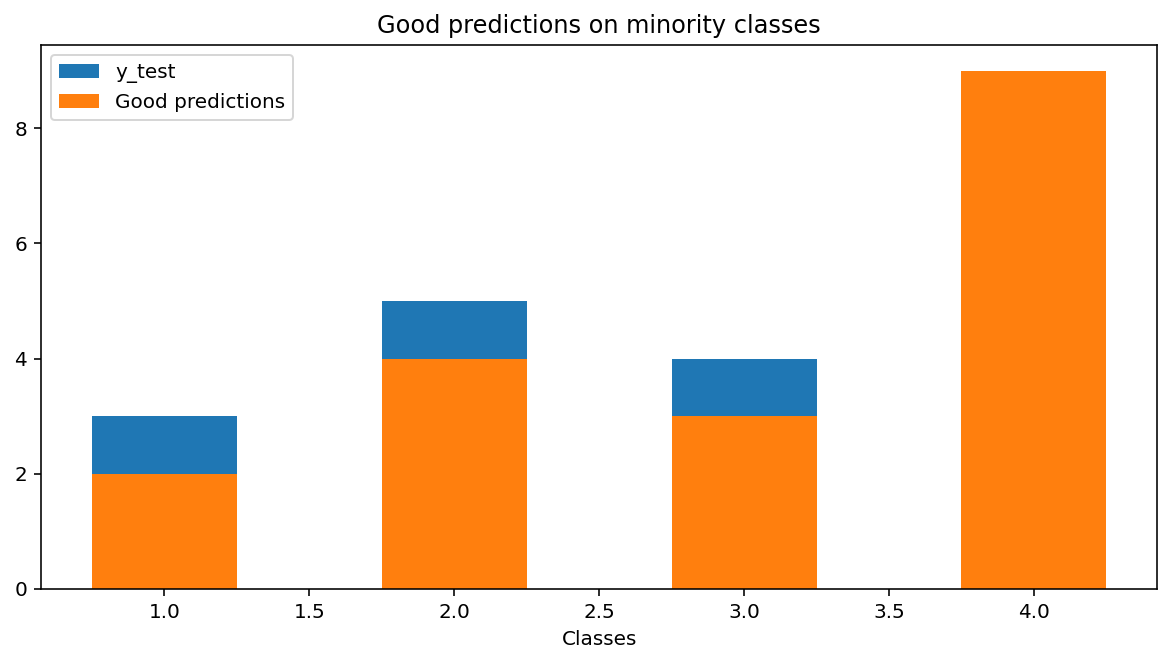

In [36]:
matrix_SVM = confusion_matrix(y_test.values, clf_rbf.predict(x_test))
acc_class_SVM = matrix_SVM.diagonal()/matrix_SVM.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_SVM.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_SVM.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

Compared to the Decision Tree case we see that we increase the overall score on the testing set. Moreover when focusing on each class, we obtain a very good accuracy for the fourth class. For the classes 1, 2 and 3 the score is better than in the case of Decision Trees.\

**Conclucion on SVM**\
The SVM classifier perfoms a global and a local better classification.
We can notice a little decrease of the accuracy for the class 0 (the majority class) which is not represented in the bar plot. However this decrease is worth the increase on the minority classes.

# Neural Network

## Pre-processing the data

In [37]:
y_k_train = to_categorical(y_train)
y_k_test = to_categorical(y_test)

## Constructing the model

In [38]:
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=12))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train.values)
class_weights = {i:class_weights[i] for i in range(0,5)}

## Training the model

In [40]:
%%time
history = model.fit(x_train, y_k_train, batch_size =8, epochs = 25, validation_data=(x_test, y_k_test),class_weight=class_weights,verbose=1)

Epoch 1/25
52/52 [==============================] - 1s 20ms/step - loss: 2.4252 - accuracy: 0.0506 - val_loss: 1.2233 - val_accuracy: 0.8418
Epoch 2/25
52/52 [==============================] - 0s 4ms/step - loss: 0.9188 - accuracy: 0.8927 - val_loss: 1.1341 - val_accuracy: 0.7288
Epoch 3/25
52/52 [==============================] - 0s 4ms/step - loss: 0.7372 - accuracy: 0.8135 - val_loss: 0.8422 - val_accuracy: 0.9096
Epoch 4/25
52/52 [==============================] - 0s 4ms/step - loss: 0.7900 - accuracy: 0.8338 - val_loss: 0.6259 - val_accuracy: 0.9548
Epoch 5/25
52/52 [==============================] - 0s 4ms/step - loss: 0.5175 - accuracy: 0.9454 - val_loss: 0.5011 - val_accuracy: 0.9492
Epoch 6/25
52/52 [==============================] - 0s 4ms/step - loss: 0.3555 - accuracy: 0.9208 - val_loss: 0.3947 - val_accuracy: 0.9548
Epoch 7/25
52/52 [==============================] - 0s 4ms/step - loss: 0.3048 - accuracy: 0.9498 - val_loss: 0.3748 - val_accuracy: 0.9548
Epoch 8/25
52/52 [=

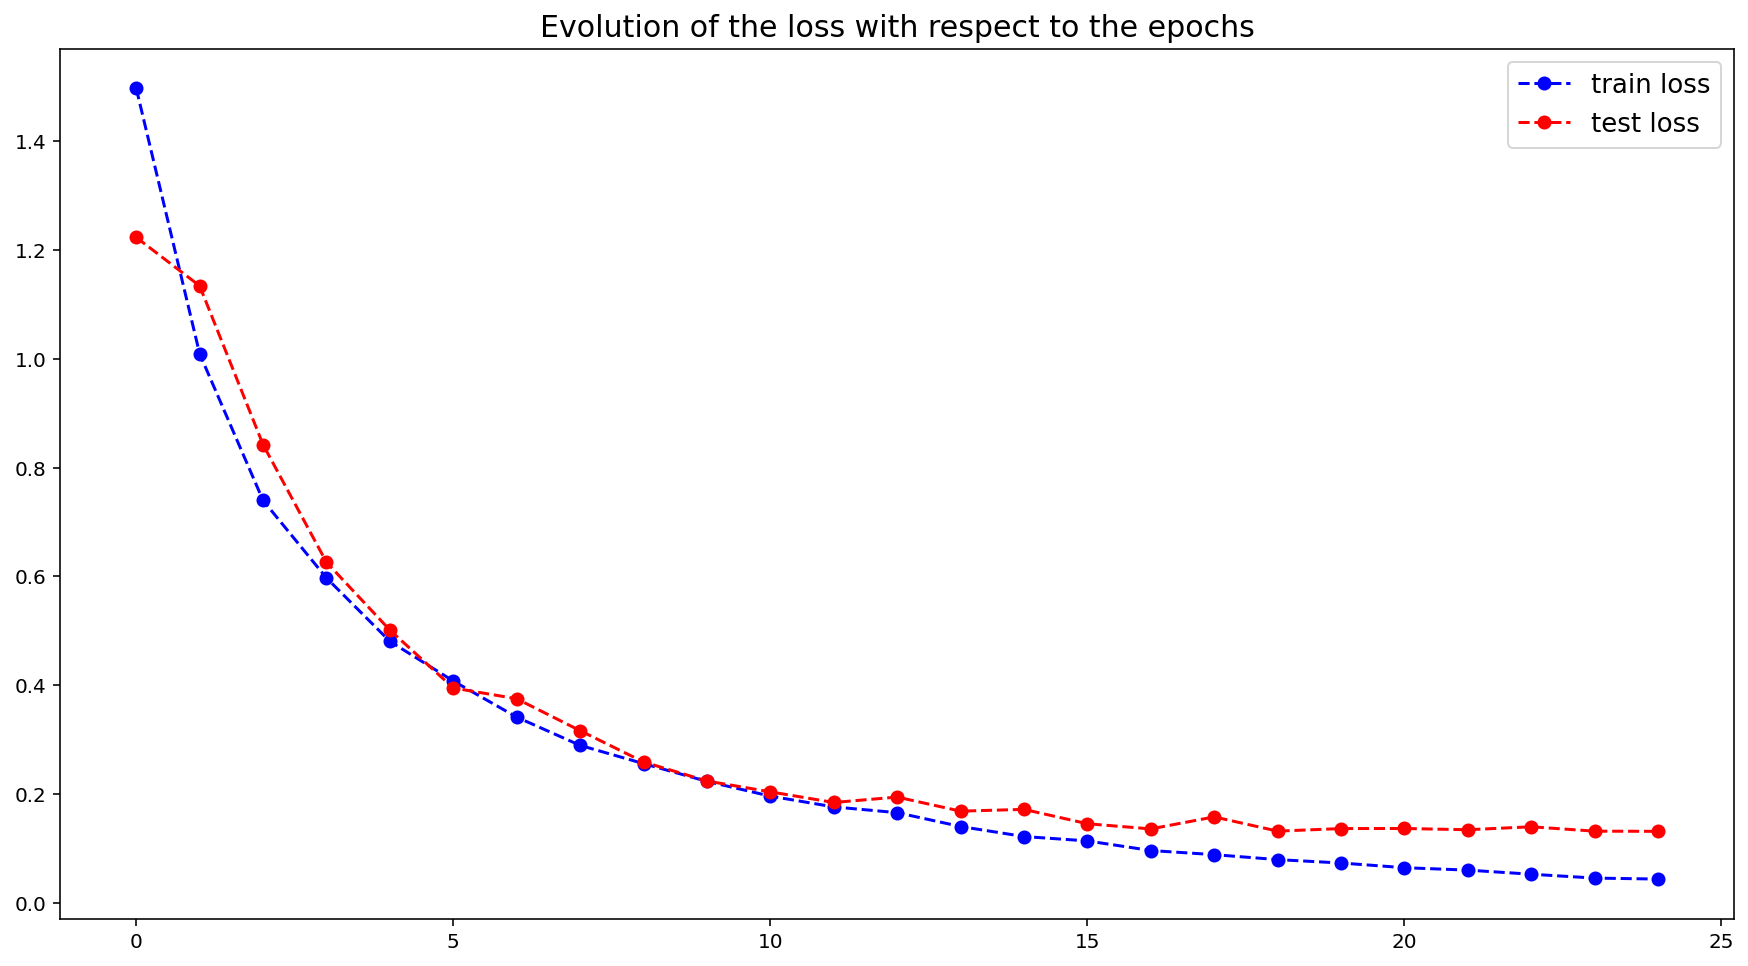

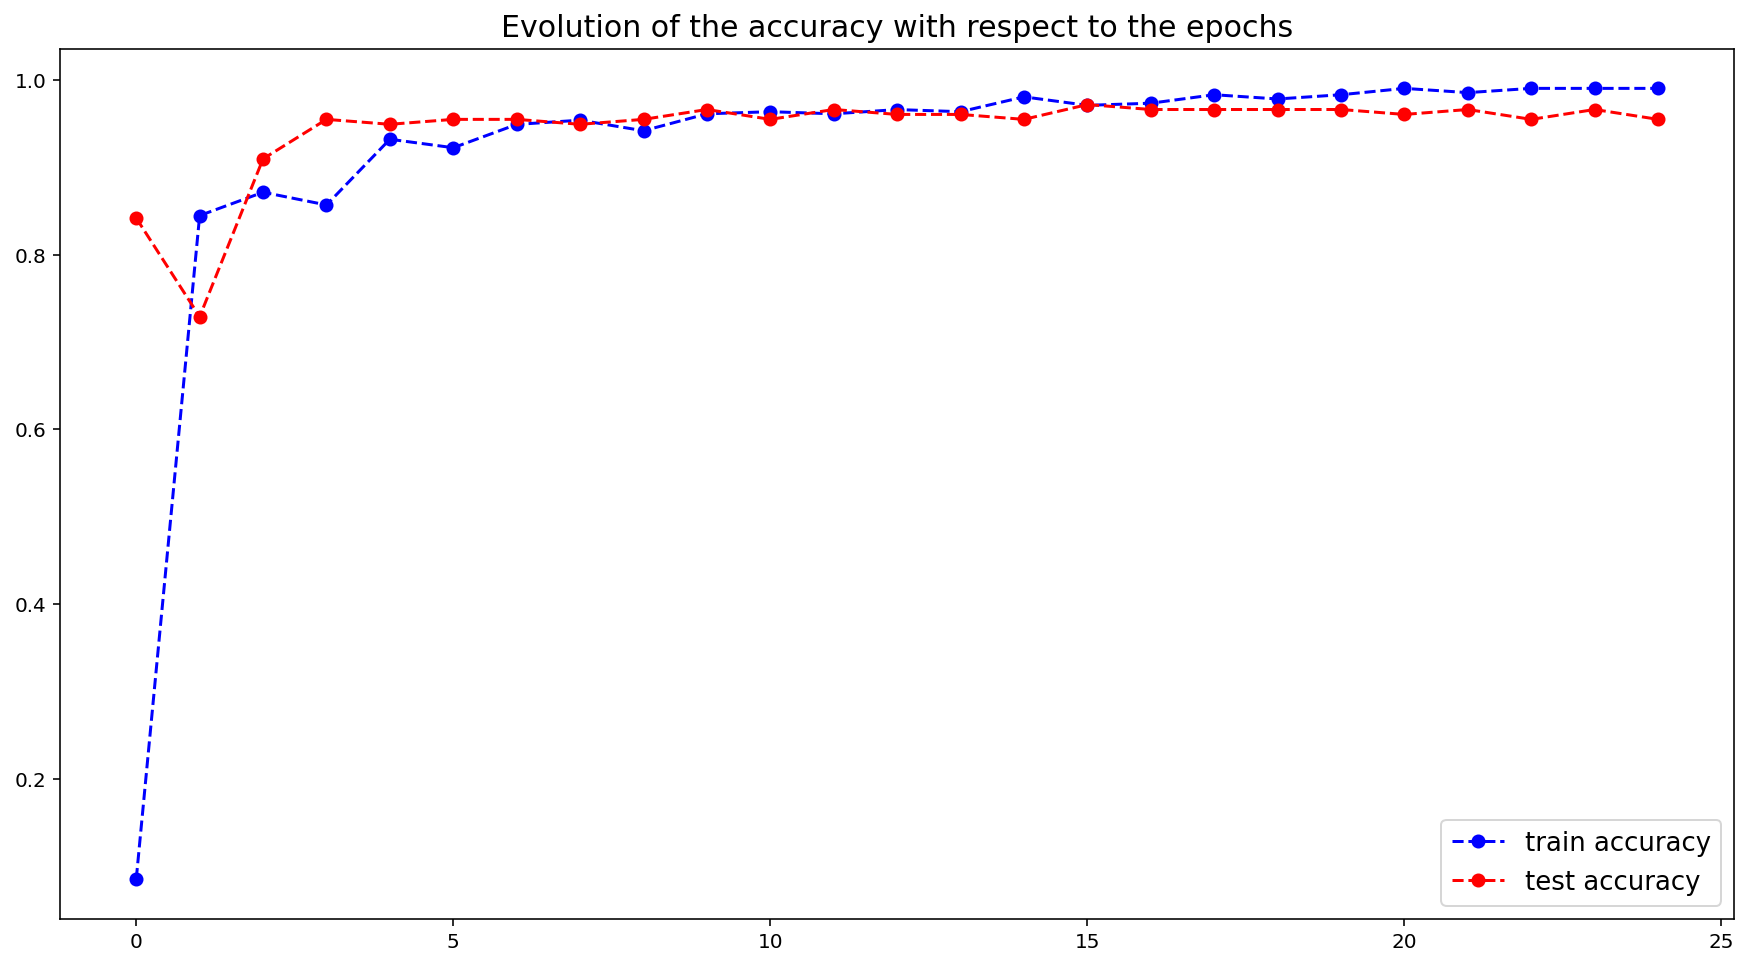

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', marker='o', linestyle='--', label='train loss')
plt.plot(val_loss, c='r', marker='o', linestyle='--', label='test loss')
plt.title('Evolution of the loss with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

plt.figure(figsize=(15,8))
plt.plot(accuracy, c='b', marker='o', linestyle='--', label='train accuracy')
plt.plot(val_accuracy, c='r', marker='o', linestyle='--', label='test accuracy')
plt.title('Evolution of the accuracy with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

The accuracy for each class is: [0.987 0.667 0.8   0.25  0.889]


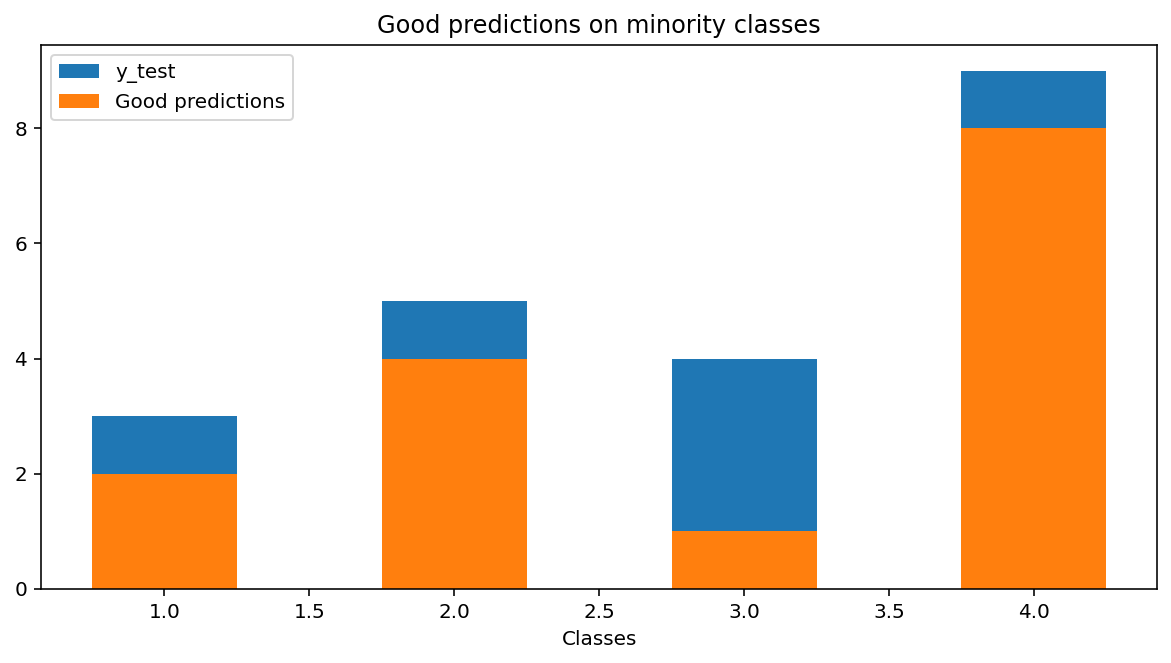

In [42]:
matrix_NN = confusion_matrix(y_test.values, np.argmax(model.predict(x_test),axis=1))
acc_class_NN = matrix_NN.diagonal()/matrix_NN.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_NN.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_NN.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

Here again, the performances are better than in the case of Decision Trees. The overall testing accuracy is comparable to SVM one, but the computation is much more time consuming. Between this NN and the SVM one might choose SVM for the speed-result ratio.

# Conclusion

**Conclusion**\
Before concluding on this multiclassification task, it is important to be careful on the fact that our results depends a lot on the initial data split. We tried to have a good repartition in term of minority classes, but results could diverge with another split.\
Concerning classifier:
> **Decision Tree**: the base results are not that bad but they mainly comes from the fact that we have a good prediction for the class 0 and average prediction for the minority classes. The fact that it does not perform well on minority classes may comes from the lack of diversity on these classes. The training time is not big but the poor performances pushed us to find other way of classifying. \
> **SVM**: Tackling the problem using SVM turned out to be efficient in time and in score. Indeed, the results obtained are good globally and locally. Globally as the score on the testing set is around 0.97% while having not too bad predictions on the minority classes. The computation is not time-consuming at all (<100ms) so this method is a strong candidate to this multiclassification task. \
> **NN**: When using neural network to classify we obtain results that are similar of those obtained with SVM. The overall accuracy on the training set is similar but the results on the minority classes is very slighty worse. However one might notice that this method is much most costly in time: more than 9s. It is not much but here we only work with approximately 600 records and one might prefer the SVM method.